### Loading raster coverages into Python

First you need to have some data to play with. If you haven't already, just run the CLI to get something to look at

In [20]:
!get_coverages --lon=122.169999 --lat=-32.42 --angle=45 test_output

Save the parameters for later

In [21]:
from shapely.geometry import Point

centre = Point(122.169999, -32.42)
angle = 45

We can then see the layers we've got to play with

In [22]:
!ls test_output/**/*

test_output/geophysics/gravity:
bouger_gravity_anomaly.tif             isostatic_residual_gravity_anomaly.tif

test_output/geophysics/magnetics:
total_magnetic_intensity.tif   variable_reduction_to_pole.tif

test_output/geophysics/radiometrics:
filtered_potassium_pct.tif    filtered_thorium_ppm.tif
filtered_terrestrial_dose.tif filtered_uranium_ppm.tif

test_output/remote_sensing/aster:
aloh_groun_content.tif            mgoh_group_content.tif
aloh_group_composition.tif        opaque_index.tif
ferric_oxide_content.tif          thermal_infrared_gypsum_index.tif
ferrous_iron_content.tif          thermal_infrared_silica_index.tif
ferrous_iron_index.tif            tir_quartz_index.tif
kaolin_group_index.tif


To load one of the coverages up, we can just use rasterio

In [36]:
from pathlib import Path
import rasterio

# What are we loading?
output = Path('test_output')
mag_tif = output / 'geophysics' / 'magnetics' / 'variable_reduction_to_pole.tif'

with rasterio.open(mag_tif, 'r') as src:
    meta = src.meta
    data = src.read(1)

Then we can see the data that we've got

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

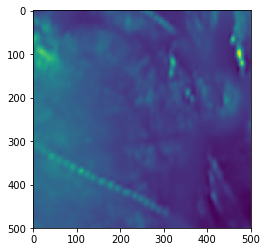

In [25]:
plt.imshow(data)

All of the layers have the same alignment and grid spacing although some will have a much lower intrinsic resolution (e.g. the gravity data). The ASTER data is generally the highest resolution (30 m pixels)

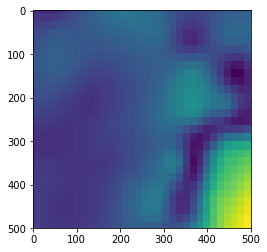

In [26]:
with rasterio.open(output / 'geophysics' / 'gravity' 
                   / 'isostatic_residual_gravity_anomaly.tif') as src:
    plt.imshow(src.read(1))

Because the data is geospatially registered you can do things like load up the geology data and extract the values for a given polygon. You might like to play with these for uncertainty quantification or feature creation.

We'll start by reusing the workflow for cropping in vector_data

In [27]:
import requests
import shutil
import zipfile
import geopandas

def download_file(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

    return local_filename

# Download data if we need to
output = Path('74619_1M_shapefiles.zip')
if not output.exists():
    download_file('https://d28rz98at9flks.cloudfront.net/74619/74619_1M_shapefiles.zip')
    
# Load up zip file
archive = zipfile.ZipFile('74619_1M_shapefiles.zip', 'r')
shapefiles = [f for f in archive.namelist() if f.endswith('shp')]
shapefiles

# Extract files from the zip
layer = 'shapefiles/GeologicUnitPolygons1M'
for fname in archive.namelist():
    if fname.startswith(layer) and not Path(fname).exists():
        archive.extract(fname)

# Load up shapefile
units = geopandas.read_file('shapefiles/GeologicUnitPolygons1M.shp')
units.head()

,GEODB_OID,OBJECTID,MAPSYMBOL,PLOTSYMBOL,STRATNO,NAME,DESCR,TYPENAME,TYPE_URI,GEOLHIST,...,FRAME,RESSCALE,CAPTDATE,MODDATE,PLOTRANK,FEATUREID,GEOLUNITID,SHAPE_LENG,SHAPE_AREA,geometry
0,None,1,Nssp,Ns,26904,Spearhole Formation,Cross bedded poorly sorted granule and pebble ...,lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Cryogenian,...,land surface,1000000,2008-11-27,2008-11-27,1,GA_GUP1M_0058707,GA.GeologicUnit.SurfaceGeology1M.26904,None,None,"POLYGON ((120.467698055 -24.37326333299995, 12..."
1,None,2,Qrc,Qrc,38491,colluvium 38491,"Colluvium and/or residual deposits, sheetwash,...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Quaternary,...,land surface,1000000,2008-11-27,2008-11-27,1,GA_GUP1M_0058805,GA.GeologicUnit.SurfaceGeology1M.38491,None,None,POLYGON ((115.2658080560001 -23.82720666699993...
2,None,3,Qa,Qa,38485,alluvium 38485,"Channel and flood plain alluvium; gravel, sand...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Holocene,...,land surface,1000000,2005-09-19,2005-09-19,1,GA_GUP1M_0058708,GA.GeologicUnit.SurfaceGeology1M.38485,None,None,"POLYGON ((143.47412308 -14.09270349999997, 143..."
3,None,4,Lshe,Ls,34024,Mamadawerre Sandstone,"White, thickly bedded, commonly tabular or tro...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Statherian to Paleoproterozoic,...,land surface,1000000,2007-07-05,2007-07-05,1,GA_GUP1M_0058709,GA.GeologicUnit.SurfaceGeology1M.34024,None,None,"POLYGON ((133.003807914 -12.78770367799996, 13..."
4,None,5,Qa,Qa,38485,alluvium 38485,"Channel and flood plain alluvium; gravel, sand...",lithostratigraphic unit,http://resource.geosciml.org/classifier/cgi/ge...,Holocene,...,land surface,1000000,2008-11-27,2008-11-27,1,GA_GUP1M_0058806,GA.GeologicUnit.SurfaceGeology1M.38485,None,None,"POLYGON ((120.967810888 -32.69829297099994, 12..."


Generate a little stamp and pull in the data

In [28]:
from explore_australia.reprojection import reproject

def clip_out(stamp, to_crs, crs='epsg:4326'):
    "Clip out the area given by the stamp polygon"
    # We first subset to the set of units that intersects with the bounding box, then generate the intersection
    stamp_reproj = reproject(stamp, crs, units.crs)
    subset = units[units.intersects(stamp_reproj)]
    clipped = subset.copy()
    clipped = clipped.intersection(stamp_reproj).to_crs(to_crs)
    return clipped

In [ ]:
from explore_australia.utilities import omerc_projection
from explore_australia.geometry import make_stamp

stamp = make_stamp(centre, angle)

# Clip the data and reproject to a locally aligned grid in m
projection = omerc_projection(centre, angle)
clipped = clip_out(stamp, crs='epsg:4326', to_crs=projection)
colluvium = clipped.loc[16288]
# colluvium

Now we can grab just the pixels over one of our units

In [45]:
from rasterio.mask import mask
from numpy import nan, nanquantile

In [43]:
with rasterio.open(mag_tif) as src:
    out_image, _ = mask(src, [colluvium], nodata=nan)

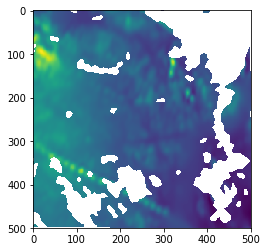

In [44]:
plt.imshow(out_image[0])

In [47]:
nanquantile(out_image.ravel(), (0.1, 0.5, 0.9))

array([-146.99163818,  -69.19237137,   43.55377502])

This might be useful for identifying anomalous geophysis modulo rock type...